### With this code we have produced maps of Biomass N kg N/ha and above-ground biomass using the RF models and not with XGB. Because, after running all training and test of RF and XGB for the Above-ground biomass and N uptake estimation, we have found RF based models performed better than XGB. Here we have processed all predictor variables and import the trained model in .pkl format and use the trained model to produce maps. we have mapped some selected dates and patches for 6 six crops to understand the transferrability of the models.

# Import necessary packages

In [28]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
import joblib
import os 
from shapely.geometry import mapping
import matplotlib.pyplot as plt
%matplotlib widget

# Step 1: Load Shapefile & Rasters: here, shp file is the polygon shp file that contain the boundary of the patches which we want to map. rasters are of multiply types. one, the specific Raster of the planet imagery which we wanted to use as input for the prediction on that specific date

In [29]:
shapefile_path = "D:/2nd_paper/GIS_RS_climate_data/shp_files/Tempelberg_all_fields/30_patches.shp"
gdf_fields = gpd.read_file(shapefile_path)

with rasterio.open("D:/2nd_paper/GIS_RS_climate_data/Rasters_for_predited_map_creation_as_final_model_output/20042021.tif") as src:
    planet_bands = [src.read(i) for i in range(1, 9)]  # Bands are 1-indexed
    profile = src.profile

elevation = rasterio.open("D:/2nd_paper/GIS_RS_climate_data/Rasters_for_predited_map_creation_as_final_model_output/elev.tif").read(1)
slope = rasterio.open("D:/2nd_paper/GIS_RS_climate_data/Rasters_for_predited_map_creation_as_final_model_output/slope.tif").read(1)
aspect = rasterio.open("D:/2nd_paper/GIS_RS_climate_data/Rasters_for_predited_map_creation_as_final_model_output/aspect.tif").read(1)

print("✅ Planet bands loaded:", len(planet_bands))
print("  Shape of each band:", planet_bands[0].shape)

print("✅ Elevation raster shape:", elevation.shape)
print("✅ Slope raster shape:", slope.shape)
print("✅ Aspect raster shape:", aspect.shape)

print("✅ Field shapefile loaded with", len(gdf_fields), "features")
print("  CRS:", gdf_fields.crs)

print("✅ Planet TIFF CRS:", profile['crs'])

assert elevation.shape == planet_bands[0].shape, "Elevation raster shape mismatch"
assert slope.shape == planet_bands[0].shape, "Slope raster shape mismatch"
assert aspect.shape == planet_bands[0].shape, "Aspect raster shape mismatch"


✅ Planet bands loaded: 8
  Shape of each band: (316, 489)
✅ Elevation raster shape: (316, 489)
✅ Slope raster shape: (316, 489)
✅ Aspect raster shape: (316, 489)
✅ Field shapefile loaded with 30 features
  CRS: EPSG:25833
✅ Planet TIFF CRS: EPSG:25833


# Calculation of Vegetation Indices from the loaded single planet image from the specific date

In [30]:
Green = planet_bands[3]     # Band 4
Red = planet_bands[5]       # Band 6
RedEdge = planet_bands[6]   # Band 7
NIR = planet_bands[7]       # Band 8

eps = 1e-6  # small constant to prevent division by zero

# Vegetation indices
NDVI = (NIR - Red) / (NIR + Red + eps)
RDVI = (NIR - Red) / np.sqrt(NIR + Red + eps)
RedEdge2 = RedEdge / (NIR + eps)
GNDVI = (NIR - Green) / (NIR + Green + eps)
NDRE = (NIR - RedEdge) / (NIR + RedEdge + eps)
EVI2 = 2.5 * (NIR - Red) / (NIR + 2.4 * Red + 1 + eps)
LCI = (NIR - Red) / (NIR + RedEdge + eps)

# ✅ Fixed MSAVI2 to prevent sqrt of negative numbers
sqrt_arg = (2 * NIR + 1)**2 - 8 * (NIR - Red + eps)
sqrt_arg = np.where(sqrt_arg < 0, 0, sqrt_arg)
MSAVI2 = 0.5 * (2 * NIR + 1 - np.sqrt(sqrt_arg))

Cl_RE = (NIR / (RedEdge + eps)) - 1
Cl_Green = (NIR / (Green + eps)) - 1
MSR = (NIR / (Red + eps)) - 1
MSR_RE = (NIR / (RedEdge + eps)) - 1
NIR_RE = NIR / (RedEdge + eps)
NIR_R = NIR / (Red + eps)

print("✅ All vegetation indices calculated safely.")


✅ All vegetation indices calculated safely.


# Rasterize Metadata: here we have produced raster of non remote sensing and topographic variables. the values specific to the image date/sampling date were picked from the main dataset.

In [31]:
# Step 1: Define field metadata
field_metadata = {
    '90': {'Crop_encoded': 4, 'BBCH': 51, 'Days_Count': 56, 'Precipitation': 40.10, 'Accumulated_PAR': 26463.45},
    '96': {'Crop_encoded': 1, 'BBCH': 31, 'Days_Count': 41, 'Precipitation': 29.50, 'Accumulated_PAR': 21096.65},
    #'73': {'Crop_encoded': 2, 'BBCH': 50, 'Days_Count': 232, 'Precipitation': 419.0, 'Accumulated_PAR':  34437.45},
    #'13': {'Crop_encoded': 0, 'BBCH': 77, 'Days_Count': 263, 'Precipitation': 480.40, 'Accumulated_PAR': 36961.454},
    #'49': {'Crop_encoded': 0, 'BBCH': 77, 'Days_Count': 263, 'Precipitation': 480.40, 'Accumulated_PAR': 36961.454},
    #'81': {'Crop_encoded': 0, 'BBCH': 77, 'Days_Count': 263, 'Precipitation': 480.40, 'Accumulated_PAR': 36961.454},
    #'60': {'Crop_encoded': 4, 'BBCH': 35, 'Days_Count': 68, 'Precipitation': 144.30, 'Accumulated_PAR': 25391},
    #'96': {'Crop_encoded': 4, 'BBCH': 35, 'Days_Count': 68, 'Precipitation': 144.30, 'Accumulated_PAR': 25391},
    #'105': {'Crop_encoded': 4, 'BBCH': 35, 'Days_Count': 68, 'Precipitation': 144.30, 'Accumulated_PAR': 25391},
    #'20': {'Crop_encoded': 5, 'BBCH': 60, 'Days_Count': 225, 'Precipitation': 372.20, 'Accumulated_PAR': 33766},
    #'50': {'Crop_encoded': 5, 'BBCH': 60, 'Days_Count': 225, 'Precipitation': 372.20, 'Accumulated_PAR': 33766},
    #'74': {'Crop_encoded': 5, 'BBCH': 60, 'Days_Count': 225, 'Precipitation': 372.20, 'Accumulated_PAR': 33766}
}

# Step 2: Get correct field name from shapefile
print("Available columns in shapefile:", gdf_fields.columns)
patch_col = 'PatchID'  # Update this if your actual column is different

# Step 3: Filter only fields 73 and 89
filtered_fields = gdf_fields[gdf_fields[patch_col].astype(str).isin(field_metadata.keys())]

# Step 4: Rasterize per-variable
meta_rasters = {}
template_shape = planet_bands[0].shape
transform = profile['transform']

for var in ['Crop_encoded', 'BBCH', 'Days_Count', 'Precipitation', 'Accumulated_PAR']:
    shapes = [
        (row.geometry, field_metadata[str(row[patch_col])][var])
        for idx, row in filtered_fields.iterrows()
    ]
    raster = rasterize(
        shapes,
        out_shape=template_shape,
        transform=transform,
        fill=np.nan,
        dtype='float32'  # ✅ fixed dtype
    )
    meta_rasters[var] = raster

print("✅ Metadata rasters created for fields 74 and others.")


Available columns in shapefile: Index(['PatchID', 'geometry'], dtype='object')
✅ Metadata rasters created for fields 74 and others.


# Visualization: Rasterized Field Metadata

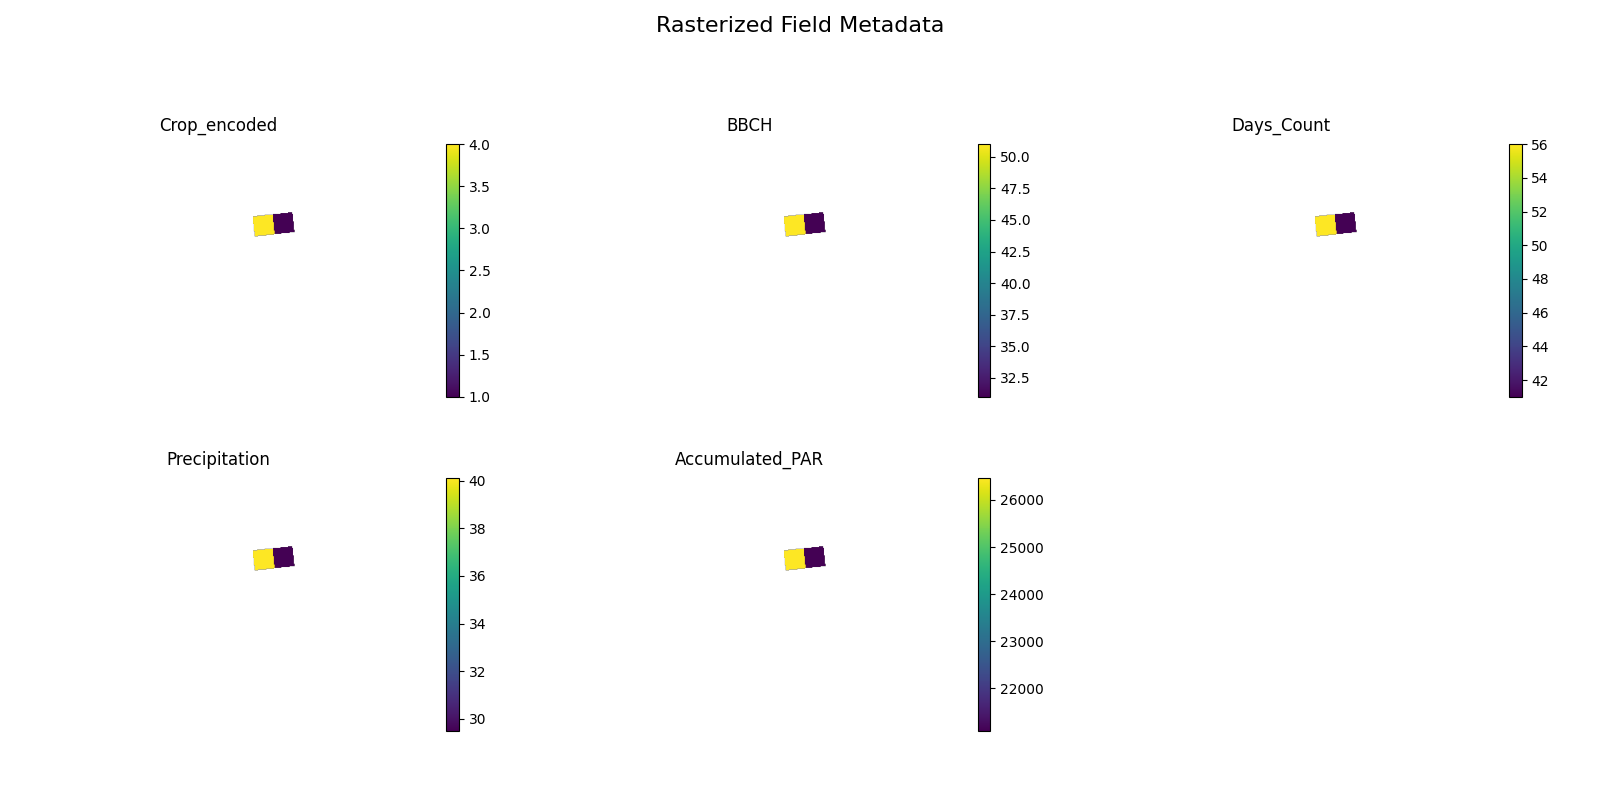

In [32]:
import matplotlib.pyplot as plt

vars_to_plot = ['Crop_encoded', 'BBCH', 'Days_Count', 'Precipitation', 'Accumulated_PAR']
n = len(vars_to_plot)

plt.figure(figsize=(16, 8))
for i, var in enumerate(vars_to_plot, 1):
    plt.subplot(2, (n + 1) // 2, i)
    plt.imshow(meta_rasters[var], cmap='viridis')
    plt.title(var)
    plt.colorbar(shrink=0.7)
    plt.axis('off')

plt.suptitle("Rasterized Field Metadata", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Stack All Features: that is stack all the variables as raster data

✅ Features stacked into array of shape: (316, 489, 26) (rows, cols, n_features)
🔄 Flattened shape: (154524, 26) (pixels, features)
✅ Valid pixels (no NaNs): 1152
❌ Invalid pixels (with NaNs): 153372


C:\Users\hossain\AppData\Roaming\Python\Python313\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  self.figure.savefig(buf, format='png', dpi='figure')


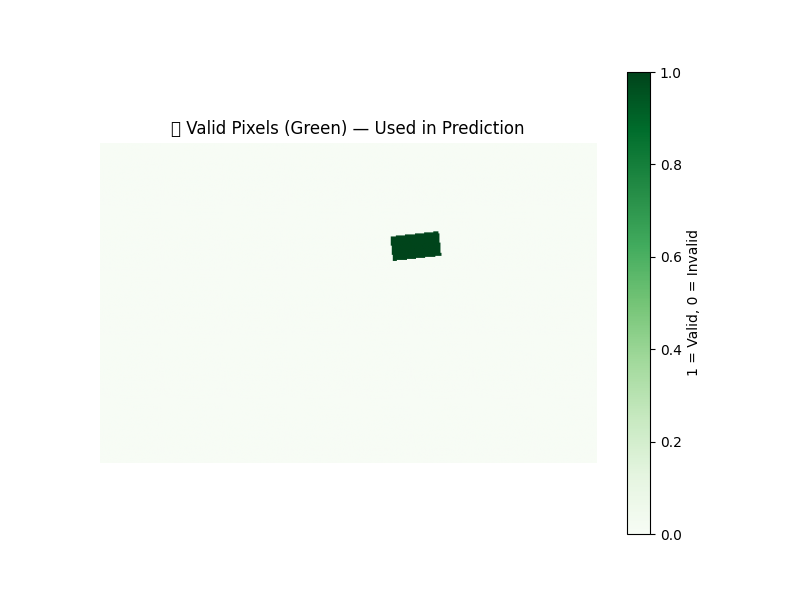

In [33]:
features = [
    planet_bands[3],  # Green (Band 4)
    planet_bands[5],  # Red (Band 6)
    planet_bands[6],  # RedEdge (Band 7)
    planet_bands[7],  # NIR (Band 8)
    elevation, slope, aspect,
    NDVI, RDVI, RedEdge2, GNDVI, NDRE, EVI2, LCI, MSAVI2,
    Cl_RE, Cl_Green, MSR, MSR_RE, NIR_RE, NIR_R,
    meta_rasters['Crop_encoded'], meta_rasters['BBCH'],
    meta_rasters['Days_Count'], meta_rasters['Precipitation'],
    meta_rasters['Accumulated_PAR']
]

# Stack all features into one 3D array
stacked = np.stack(features, axis=-1)
rows, cols, n_feats = stacked.shape
print(f"✅ Features stacked into array of shape: {stacked.shape} (rows, cols, n_features)")

# Flatten to (num_pixels, n_features)
X_flat = stacked.reshape(-1, n_feats)
print(f"🔄 Flattened shape: {X_flat.shape} (pixels, features)")

# Mask out pixels with any NaNs
mask_valid = ~np.any(np.isnan(X_flat), axis=1)
X_clean = X_flat[mask_valid]
print(f"✅ Valid pixels (no NaNs): {X_clean.shape[0]}")
print(f"❌ Invalid pixels (with NaNs): {X_flat.shape[0] - X_clean.shape[0]}")

# Reshape the valid pixel mask back to 2D
mask_map = mask_valid.reshape((rows, cols))

# Plot valid pixel locations
plt.figure(figsize=(8, 6))
plt.imshow(mask_map, cmap='Greens')
plt.title("✅ Valid Pixels (Green) — Used in Prediction")
plt.colorbar(label="1 = Valid, 0 = Invalid")
plt.axis('off')
plt.show()


# Predict with RF/XGBOOST: in our case it's RF. the trained RF model was saved as pkl file in the RF workflow notebook

In [34]:
# Load trained XGBoost model
model = joblib.load("D:/2nd_paper/GIS_RS_climate_data/Rasters_for_predited_map_creation_as_final_model_output/final_rf_model_Bio_Dm.pkl")

# Predict Bio_N for valid pixels
y_pred = model.predict(X_clean)

# Preview prediction output
y_pred


C:\Users\hossain\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([3911.81314244, 3570.24461443, 3513.94156037, ..., 3982.1645285 ,
       3921.92839071, 3989.81204766])

# Save Prediction Map as tif

In [35]:
# Create an empty 1D array and insert predictions
output = np.full((rows * cols,), np.nan)
output[mask_valid] = y_pred

# Reshape to original spatial shape
output_2D = output.reshape((rows, cols))

# Define output path
output_path = "Bio_Dm_Prediction_Map_20042021.tif"

# Update the raster profile
profile.update(dtype='float32', count=1, compress='lzw')

# Write the GeoTIFF
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(output_2D.astype(np.float32), 1)

print(f"✅ Prediction map saved to: {output_path}")

✅ Prediction map saved to: Bio_Dm_Prediction_Map_26062023.tif


# Visualize Prediction

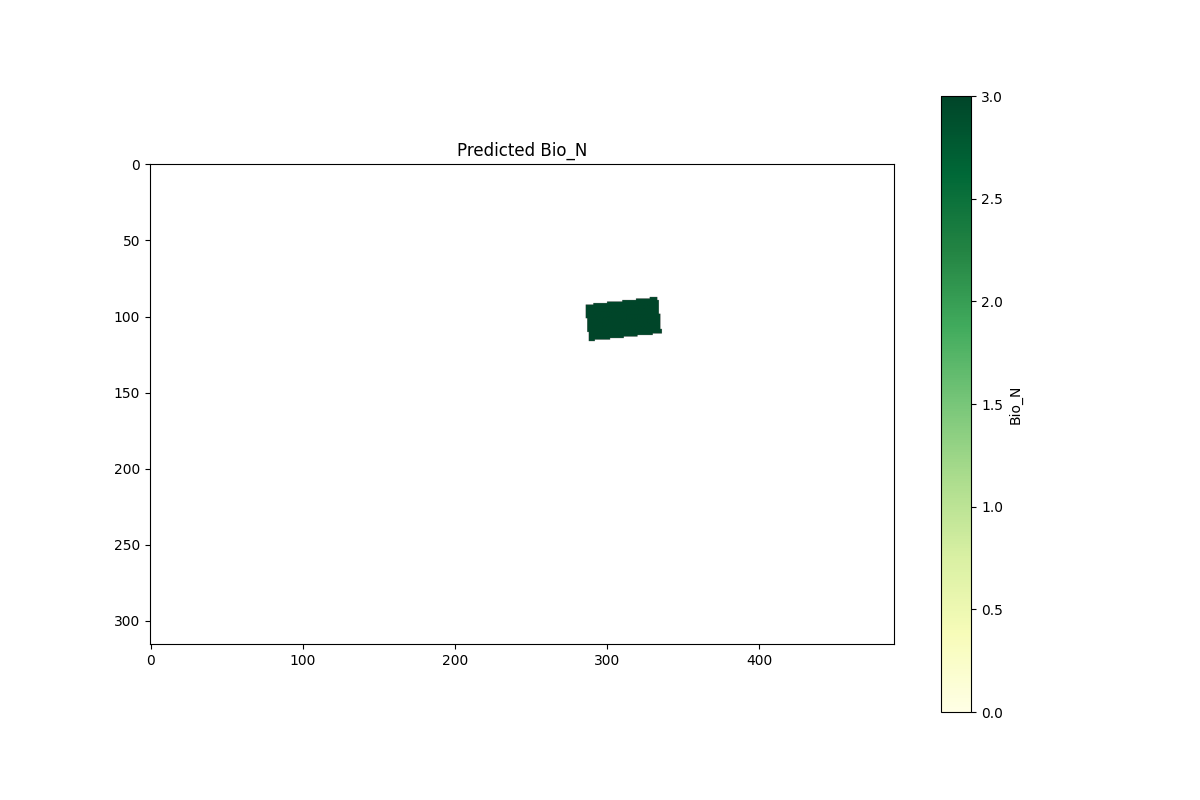

In [36]:
plt.figure(figsize=(12, 8))
plt.imshow(output_2D, cmap='YlGn', vmin=0, vmax=3)
plt.title("Predicted Bio_N")
plt.colorbar(label='Bio_N')
plt.axis('on')  # Optional: remove axis ticks for cleaner output
plt.show()
